### Tasks:
1. **Environment setup**
2. **Data preparation**
4. **Model Building**
6. **Model Evaluation**


## Environment setup

In [1]:
# Importing Libraries
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import re
import string
import time
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,Conv1D, Bidirectional, LSTM,Dropout,Input,Embedding,TextVectorization)
from keras.preprocessing.text import one_hot, Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

### Local setup

In [ ]:
from keras_preprocessing.sequence import pad_sequences

# Local Path
root_path = "/Users/loc/Desktop/Git/23mse43006/7.ML/FinalAssignment/application/models/sentiment_analysic/"

ModuleNotFoundError: No module named 'keras_preprocessing'

### Google Colab

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#  Google Drive Path
root_path = "/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/"

Mounted at /content/drive


In [3]:
data_path = root_path + "data_set/"
checkpoint_filepath = root_path + "check_points/"
embeddings = root_path + "embeddings/"
saved_model_path = root_path + "output/"

## Data preparation


### Load IMDb dataset(50,000 records)


In [4]:
movie_reviews = pd.read_csv(data_path + "imdb_dataset_50k.csv")

### Explore the dataset

In [ ]:
# Check the shape of the dataset
movie_reviews.shape

(50000, 2)

In [5]:
# Check for missing values
movie_reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
# Display the first 5 rows of the dataset
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

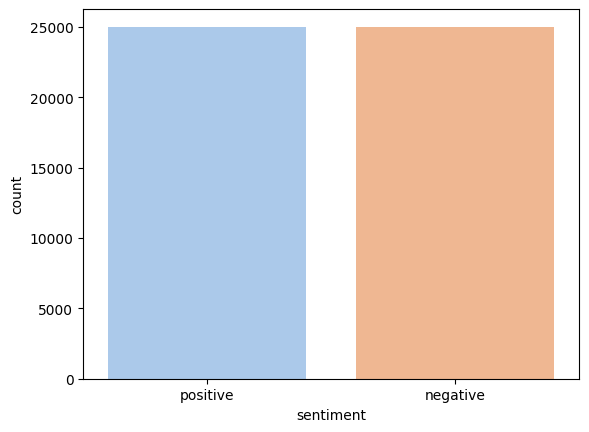

In [ ]:
# Plot the count of each sentiment
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

### Convert the sentiment column to binary

In [ ]:
# Convert the sentiment column to binary
movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

<Axes: xlabel='sentiment', ylabel='count'>

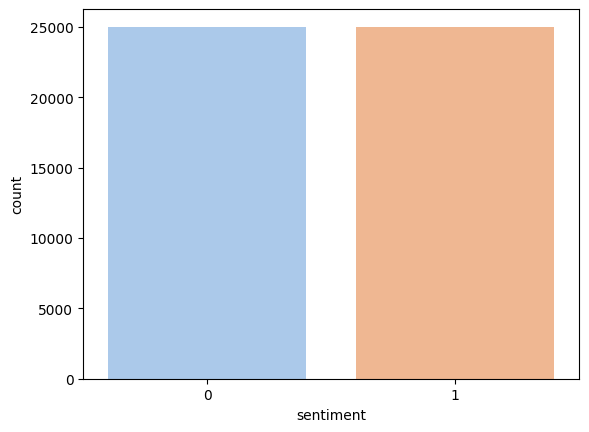

In [ ]:
# Plot the count of each sentiment
sns.countplot(x='sentiment', data=movie_reviews, hue='sentiment', palette='pastel', legend=False)

### Split the dataset into training, validation, and test sets

In [ ]:
# 1. Split according to the common ratio:

# 	•	Training set: 70% (35,000 records)
# 	•	Validation set: 15% (7,500 records)
# 	•	Test set: 15% (7,500 records)

train_data, temp_data = train_test_split(movie_reviews, test_size=0.3, random_state=42)

val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate the features (reviews) and labels (sentiments) for each set
X_train, y_train = train_data['review'], train_data['sentiment']
X_val, y_val = val_data['review'], val_data['sentiment']
X_test, y_test = test_data['review'], test_data['sentiment']

## Preparing embedding layer

### Manual

In [ ]:
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(X_train) # create a dictionary

# X_train = word_tokenizer.texts_to_sequences(X_train) # match the words in the dictionary to the words in the sentences
# X_test = word_tokenizer.texts_to_sequences(X_test)
# len(word_tokenizer.word_index)
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

# vocab_length = len(word_tokenizer.word_index) + 1

# vocab_length
# len(X_train)
# for i in range(10):
#     print(len(X_train[i]))
# Padding all reviews to fixed length 100

# maxlen = 100

# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# len(X_train)
# for i in range(10):
#     print(X_train)

### Keras TextVectorization

#### Standardize data

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import unicodedata

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Convert the stopwords to a TensorFlow constant
stopwords_tensor = tf.constant(list(stop_words))

def remove_stopwords(sentence):
    words = tf.strings.split(sentence)
    filtered_words = tf.boolean_mask(words, tf.math.logical_not(tf.reduce_any(tf.equal(words[:, None], stopwords_tensor[None, :]), axis=1)))
    sentence = tf.strings.reduce_join(filtered_words, separator=' ')
    return sentence

def standardization(sen):

    lowercase = tf.strings.lower(sen)

    # Remove punctuations and numbers
    sentence = tf.strings.regex_replace(lowercase, '[^a-z]', ' ')

    # Take off of html tag
    sentence = tf.strings.regex_replace(sentence, '<[^>]+>', ' ')

    # Single character removal
    sentence = tf.strings.regex_replace(sentence, r'\b\w\b', ' ')

    # Remove multiple spaces
    sentence = tf.strings.regex_replace(sentence, ' +', ' ')

    # Remove stopwords #FIXME
    # sentence = remove_stopwords(sentence)

    # Normalize UTF-8 and remove accented characters using standard Python libraries #FIXME
    # def normalize_and_remove_accents(text):
    #     text = unicodedata.normalize('NFKD', text.numpy().decode('utf-8'))
    #     return ''.join(c for c in text if unicodedata.category(c) != 'Mn')

    # sentence = tf.py_function(normalize_and_remove_accents, [sentence], tf.string)

    return sentence

In [ ]:
# movie_reviews['review'][2]
# Example usage
sentence = tf.constant("lộc This is a sample sentence, showing off the stop words filtration.")
standardization(sentence)
standardization(movie_reviews['review'][2])

#### **TextVectorization: tokenization, vectorization, and building vocabulary**

In [ ]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250

# Create a TextVectorization layer to vectorize and standardize text data for the model
# Include tokenization, standardization, and vectorization in one layer
vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

print("Building the dictionary...")

start_time = time.time()

# Only extract the train from the dataset
vectorize_layer.adapt(train_data.map(lambda train, label: train))

end_time = time.time()

print("Time taken to build the dictionary: ", end_time - start_time)


Building the dictionary...
Time taken to build the dictionary:  61.6909019947052


In [ ]:
# print 4 first records of X_val
for i in range(4):
    print(X_val.iloc[i])

I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the

In [ ]:
# Display the words in the vocabulary with their vector representations
# for i in range(1):
#     print(X_train[i])
#     print(vectorize_layer(X_val[i]))

# print X_val
for i in range(1):
    print(X_val.iloc[i])
    print(vectorize_layer(X_val.iloc[i]))

I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the

In [ ]:
vectorize_layer.get_vocabulary()[22]

'are'

In [ ]:
print("Starting vectorization...")

def vectorizer(review, label):
    return vectorize_layer(review),label

start_time = time.time()

train_dataset = train_data.map(lambda x, y: (vectorize_layer(x), y))
val_dataset = val_data.map(lambda x, y: (vectorize_layer(x), y))

end_time = time.time()

print("Time taken to vectorize the dataset: ", end_time - start_time)

Starting vectorization...
Time taken to vectorize the dataset:  0.13966035842895508


## Models Training:

### **Simple RNN:**

#### **Build the model**

In [ ]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

# Initialize the Sequential model
model_simple_rnn=tf.keras.models.Sequential([

    # Input layer with the defined sequence length
    Input(shape=(SEQUENCE_LENGTH,)),

    # Embedding layer converting word indices to dense vectors
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),

    # Simple RNN layer with 32 units
    SimpleRNN(32),

    # Output layer with 1 unit and sigmoid activation for binary classification
    Dense(1,activation='sigmoid'),
])

model_simple_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_simple_rnn_checkpoint.keras" ,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model_simple_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model_simple_rnn.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_callback])

model_simple_rnn.save(saved_model_path + "imdb_simple_rnn.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/15
547/547 [==============================] - 92s 168ms/step - loss: 0.3370 - accuracy: 0.8687 - val_loss: 0.4636 - val_accuracy: 0.7783
Epoch 2/15
547/547 [==============================] - 91s 167ms/step - loss: 0.3036 - accuracy: 0.8829 - val_loss: 0.4483 - val_accuracy: 0.7981
Epoch 3/15
547/547 [==============================] - 89s 162ms/step - loss: 0.2895 - accuracy: 0.8881 - val_loss: 0.4563 - val_accuracy: 0.7972
Epoch 4/15
547/547 [==============================] - 91s 166ms/step - loss: 0.2842 - accuracy: 0.8886 - val_loss: 0.5021 - val_accuracy: 0.7855
Epoch 5/15
547/547 [==============================] - 89s 163ms/step - loss: 0.2527 - accuracy: 0.9057 - val_loss: 0.5142 - val_accuracy: 0.7848
Epoch 6/15
547/547 [==============================] - 89s 163ms/step - loss: 0.2177 - accuracy: 0.9244 - val_loss: 0.4878 - val_accuracy: 0.7967
Epoch 7/15
547/547 [==============================] - 89s 163ms/step - loss: 0.1881 - accuracy: 0.9383 - val

#### **Plotting model loss and accuracy**

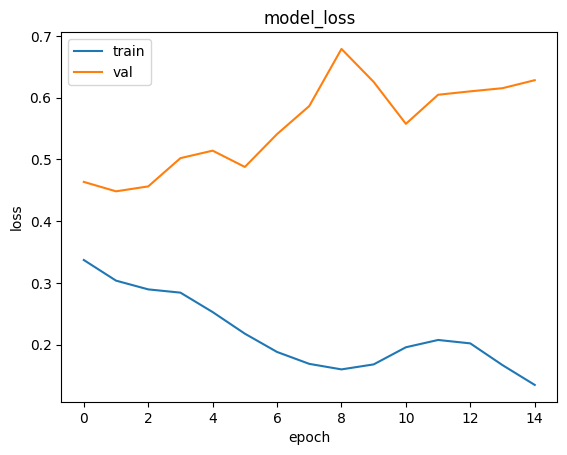

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

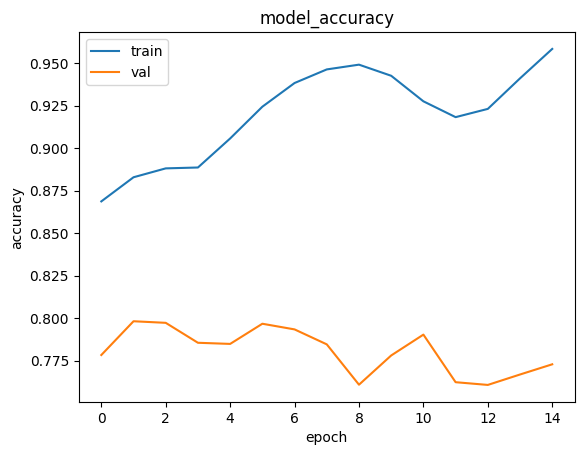

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model_simple_rnn.evaluate(test_dataset)

118/118 [==============================] - 3s 21ms/step - loss: 0.6494 - accuracy: 0.7659


[0.6494171619415283, 0.7658666372299194]

### **LSTM (MultiLayer and Bidirectional):**

#### **Build the model**

In [ ]:
# 2. Early Stopping with Lower Patience: Reduce the patience parameter in the early stopping callback to prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Add More Data: If possible, augment the training dataset to provide more examples for the model to learn from. ??

In [ ]:
# Define hyperparameters
# 1. Batch size for training and validation (64)
BATCH_SIZE=64
# 2. Maximum vocabulary size (10,000)
VOCAB_SIZE=10000
# 3. Maximum sequence length to pad the sentences to (250)
SEQUENCE_LENGTH=250
# 4. Embedding dimension (64)
EMBEDDING_DIM = 64

model_lstm =tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    # 1. Increase Dropout Rate: To combat overfitting, consider increasing the dropout rate.
    Dropout(0.7),
    # 5.	Reduce Model Complexity: Simplify the model by reducing the number of LSTM units or layers to prevent overfitting.
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.7),
    # 4. Regularization Techniques: Implement L2 regularization to penalize large weights and prevent overfitting.
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 128)          66048     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 250, 128)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_lstm_checkpoint.keras" ,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Mac M1/M2 happy with legacy: tf.keras.optimizers.legacy.Adam(1e-4)
model_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(1e-4), #tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Model training
start_time = time.time()

print("Training the model...")


BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=model_lstm.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint_callback, early_stopping])

model_lstm.save(saved_model_path + "imdb_lstm.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/15
547/547 [==============================] - 52s 86ms/step - loss: 0.6504 - accuracy: 0.6085 - val_loss: 0.4035 - val_accuracy: 0.8396
Epoch 2/15
547/547 [==============================] - 20s 36ms/step - loss: 0.3617 - accuracy: 0.8684 - val_loss: 0.3204 - val_accuracy: 0.8744
Epoch 3/15
547/547 [==============================] - 20s 36ms/step - loss: 0.2774 - accuracy: 0.9082 - val_loss: 0.3187 - val_accuracy: 0.8769
Epoch 4/15
547/547 [==============================] - 20s 36ms/step - loss: 0.2380 - accuracy: 0.9250 - val_loss: 0.3384 - val_accuracy: 0.8736
Epoch 5/15
547/547 [==============================] - 20s 36ms/step - loss: 0.2103 - accuracy: 0.9377 - val_loss: 0.3706 - val_accuracy: 0.8691
Time taken to train the model:  131.68696451187134


#### **Plot both training and validation metrics:**

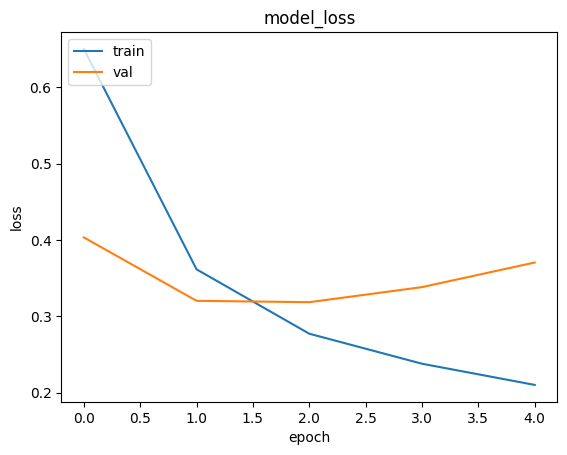

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

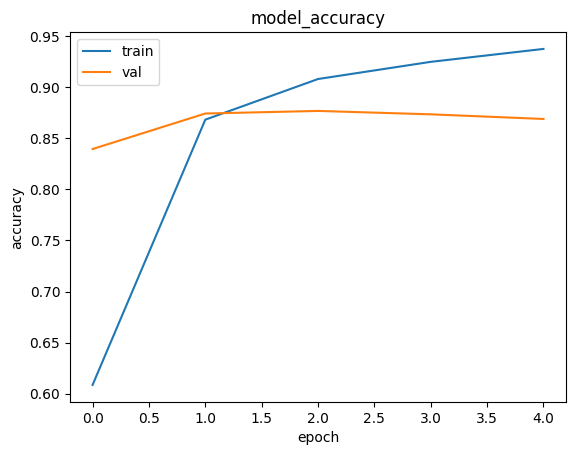

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model_lstm.evaluate(test_dataset)

118/118 [==============================] - 2s 19ms/step - loss: 0.3146 - accuracy: 0.8805


[0.31461265683174133, 0.8805333375930786]

### **Pretrained Word2Vec[Gensim]**

#### **Build the model**

In [ ]:
# 2. Early Stopping with Lower Patience: Reduce the patience parameter in the early stopping callback to prevent overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Add More Data: If possible, augment the training dataset to provide more examples for the model to learn from. ??

In [ ]:
# import gensim.downloader as api
import gensim

# word2vec = api.load('word2vec-google-news-300')

# Load the model
word2vec = gensim.models.KeyedVectors.load_word2vec_format(embeddings + "GoogleNews-vectors-negative300.bin", binary=True)
# word2vec.vectors.shape

In [ ]:
# Testing purpose
# print(word2vec.vocab)
word2vec['The']
# word2vec.most_similar('Man')
# word2vec.key_to_index

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
import numpy as np
import random

# Assuming vectorize_layer and word2vec are already defined
vectorize_layer_vocabulary = vectorize_layer.get_vocabulary()
embedding_dim = pretrained_embeddings_array.shape[1]
pretrained_embeddings = []

unfound_words = []
unfound_words_count = 0
found_words_count = 0

# Preallocate space for embeddings
pretrained_embeddings = np.zeros((len(vectorize_layer_vocabulary), embedding_dim))

# Fill the embeddings array
for i, word in enumerate(vectorize_layer_vocabulary):
    if word in word2vec.key_to_index:
        found_words_count += 1
        pretrained_embeddings[i] = word2vec[word]
    else:
        unfound_words_count += 1
        unfound_words.append(word)
        pretrained_embeddings[i] = np.zeros(embedding_dim)  # Or use random.normal if preferred

    if i % 1000 == 0:
        print(f'Processed {i} words out of {len(vectorize_layer_vocabulary)}')

print(f"Found words count: {found_words_count}")
print(f"Unfound words count: {unfound_words_count}")
print(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

# Uncomment to print unfound words
# for word in unfound_words:
#     print(word)

Processed 0 words out of 10000
Processed 1000 words out of 10000
Processed 2000 words out of 10000
Processed 3000 words out of 10000
Processed 4000 words out of 10000
Processed 5000 words out of 10000
Processed 6000 words out of 10000
Processed 7000 words out of 10000
Processed 8000 words out of 10000
Processed 9000 words out of 10000
Found words count: 9542
Unfound words count: 458
Pretrained embeddings shape: (10000, 300)


In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/sentiment_analysis/embeddings/pretrained_embeddings", np.array(pretrained_embeddings))

In [ ]:
pretrained_embeddings_array=np.load(embeddings + "pretrained_embeddings.npy" )
pretrained_embeddings_array.shape[1]

300

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Define hyperparameters
BATCH_SIZE = 64
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250
EMBEDDING_DIM = pretrained_embeddings_array.shape[1]

# Build the model
lstm_pretrained_embedding_model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),

    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True
    ),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),

    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid'),
])

# Display the model's architecture
lstm_pretrained_embedding_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 bidirectional_9 (Bidirecti  (None, 250, 128)          186880    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 250, 128)          0         
                                                                 
 batch_normalization (Batch  (None, 250, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_10 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                      

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath + "imdb_lstm_word2vec_checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
lstm_pretrained_embedding_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Model training
start_time = time.time()

print("Training the model...")

BATCH_SIZE=64

# Batch and prefetch the dataset
train_data = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

history=lstm_pretrained_embedding_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[model_checkpoint_callback, early_stopping])

lstm_pretrained_embedding_model.save(saved_model_path + "imdb_lstm_word2vec.keras")

end_time = time.time()

print("Time taken to train the model: ", end_time - start_time)

Training the model...
Epoch 1/10
547/547 [==============================] - 80s 133ms/step - loss: 6.2054 - accuracy: 0.5295 - val_loss: 4.1361 - val_accuracy: 0.6631
Epoch 2/10
547/547 [==============================] - 47s 87ms/step - loss: 3.1625 - accuracy: 0.6961 - val_loss: 2.4496 - val_accuracy: 0.7824
Epoch 3/10
547/547 [==============================] - 48s 87ms/step - loss: 1.9271 - accuracy: 0.8301 - val_loss: 1.5679 - val_accuracy: 0.8488
Epoch 4/10
547/547 [==============================] - 47s 86ms/step - loss: 1.3422 - accuracy: 0.8667 - val_loss: 1.1203 - val_accuracy: 0.8753
Epoch 5/10
547/547 [==============================] - 48s 87ms/step - loss: 0.9900 - accuracy: 0.8870 - val_loss: 0.8844 - val_accuracy: 0.8765
Epoch 6/10
547/547 [==============================] - 48s 87ms/step - loss: 0.7708 - accuracy: 0.8991 - val_loss: 0.7506 - val_accuracy: 0.8789
Epoch 7/10
547/547 [==============================] - 47s 85ms/step - loss: 0.6265 - accuracy: 0.9119 - val_loss:

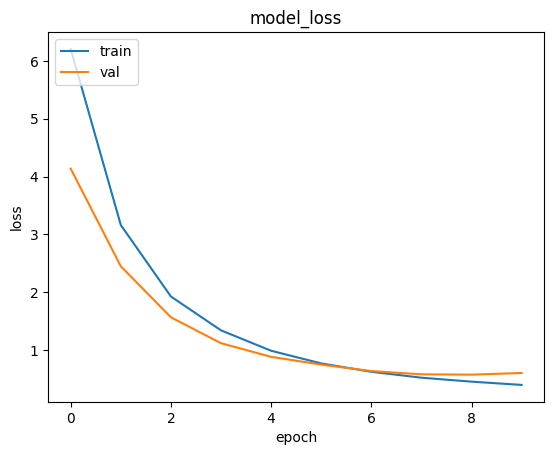

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

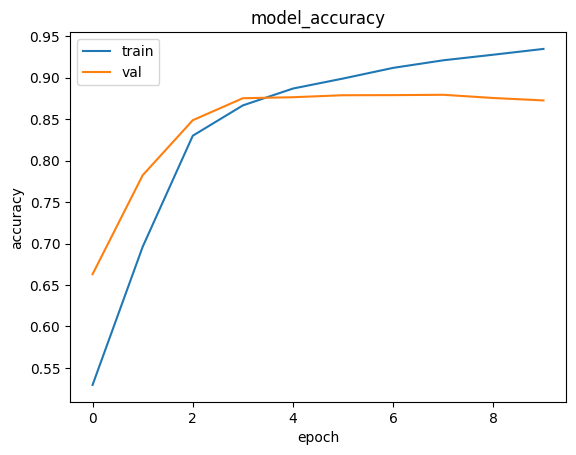

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Evaluate the model**

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset=test_data.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
lstm_pretrained_embedding_model.evaluate(test_dataset)

118/118 [==============================] - 2s 20ms/step - loss: 0.6146 - accuracy: 0.8692


[0.6145737171173096, 0.8691999912261963]